## Análise com recorte temporal (Pré Galácticos)

**Disciplina: Redes Sociais**

**Grupo: Antonio Fuziy, Eiki Yamashiro e Marcelo Cesário**

___


#### Importação das bibliotecas

In [1]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral,centrality
import statsmodels.formula.api as smf

from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm
import difflib
import seaborn as sns
from matplotlib import rcParams

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [2]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['spanish_primera_division.csv',
 'dutch_eredivisie.csv',
 'portugese_liga_nos.csv',
 'french_ligue_1.csv',
 'italian_serie_a.csv',
 'russian_premier_liga.csv',
 'english_premier_league.csv',
 'english_championship.csv',
 'german_bundesliga_1.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [3]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    primeiro = 0
    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[0:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            if primeiro == 0:
                data = data_temp
                primeiro = 1
            else:
                # Concatenação dos dados
                data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [4]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
# data

In [5]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [6]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

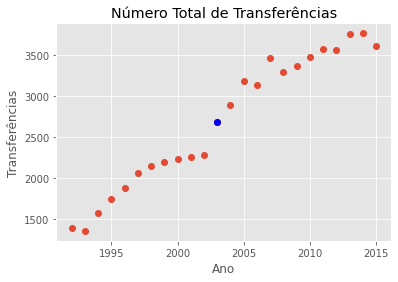

In [7]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

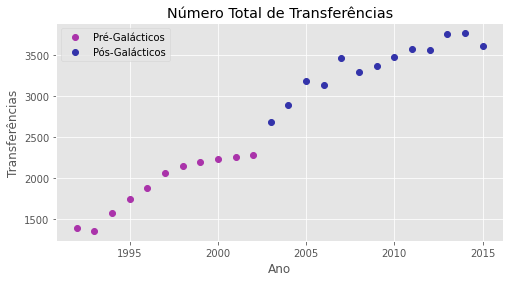

In [8]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [9]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [10]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
# data_in

In [11]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [12]:
rede_pos_gal = Graph(directed=True) # dirigido
rede_pos_gal.vp['name'] = rede_pos_gal.new_vp('object')
rede_pos_gal.vp['league'] = rede_pos_gal.new_vp('object')
rede_pos_gal.ep["transfer"] = rede_pos_gal.new_ep('object')

In [13]:
times = []
for index, rows in data_pos_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        rede_pos_gal.add_vertex()
        v_time = rede_pos_gal.vertex(times.index(time1))
        rede_pos_gal.vp['name'][v_time] = time1
        rede_pos_gal.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        rede_pos_gal.add_vertex()
        v_time = rede_pos_gal.vertex(times.index(time2))
        rede_pos_gal.vp['name'][v_time] = time2
        rede_pos_gal.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if rede_pos_gal.edge(index1, index2) == None:
        rede_pos_gal.add_edge(index1, index2)
        e = rede_pos_gal.edge(index1, index2)
        rede_pos_gal.ep["transfer"][e] = 1
    else:
        e = rede_pos_gal.edge(index1, index2)
        rede_pos_gal.ep["transfer"][e] = rede_pos_gal.ep["transfer"][e] + 1

In [14]:
data_in["league_name"].value_counts()

Championship        12342
Premier League       9652
Serie A              7532
Liga Nos             7382
Ligue 1              6365
Primera Division     5988
Eredivisie           5608
1 Bundesliga         5163
Premier Liga         4923
Name: league_name, dtype: int64

In [15]:
data_in[data_in['league_name']=='Serie A'][0:50]

,index,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
561,0,Milan AC,Jean-Pierre Papin,28.0,Centre-Forward,Olympique Marseille,£10.80m,in,Summer,10.800,Serie A,1992,1992/1993
562,1,Milan AC,Gianluigi Lentini,23.0,Right Winger,Torino Calcio,£8.60m,in,Summer,8.600,Serie A,1992,1992/1993
563,2,Milan AC,Dejan Savicevic,25.0,Attacking Midfield,Red Star,£4.14m,in,Summer,4.140,Serie A,1992,1992/1993
564,3,Milan AC,Guido Bistazzoni,32.0,Goalkeeper,Taranto,?,in,Summer,NaN,Serie A,1992,1992/1993
565,4,Milan AC,Fernando De Napoli,28.0,Central Midfield,SSC Napoli,?,in,Summer,NaN,Serie A,1992,1992/1993
566,5,Milan AC,Davide Dionigi,18.0,Centre-Forward,Modena FC,?,in,Summer,NaN,Serie A,1992,1992/1993
567,6,Milan AC,Stefano Eranio,25.0,Right Midfield,Genoa 1893,?,in,Summer,NaN,Serie A,1992,1992/1993
568,7,Milan AC,Martino Traversa,18.0,Right-Back,Bologna FC 1909,?,in,Summer,NaN,Serie A,1992,1992/1993
569,8,Milan AC,Giuseppe Cardone,18.0,Right-Back,Milan U19,-,in,Summer,0.000,Serie A,1992,1992/1993
570,9,Milan AC,Giuseppe Zappella,19.0,Right-Back,Milan U19,-,in,Summer,0.000,Serie A,1992,1992/1993


In [16]:
rede_pos_gal.vp['color'] = rede_pos_gal.new_vp('object')

for v in rede_pos_gal.vertices():
    if rede_pos_gal.vp['league'][v] == "Premier League":
        rede_pos_gal.vp['color'][v] = 0x61dafb
        #61dafb
    if rede_pos_gal.vp['league'][v] == "Eredivisie":
        rede_pos_gal.vp['color'][v] = 0x915bff
        #915bff
    if rede_pos_gal.vp['league'][v] == "Championship":
        rede_pos_gal.vp['color'][v] = 0xbababa
        #bababa
    if rede_pos_gal.vp['league'][v] == "Serie A":
        rede_pos_gal.vp['color'][v] = 0x00ff00
        #00ff00
    if rede_pos_gal.vp['league'][v] == "Liga Nos":
        rede_pos_gal.vp['color'][v] = 0xffa7b6
        #ffa7b6
    if rede_pos_gal.vp['league'][v] == "Ligue 1":
        rede_pos_gal.vp['color'][v] = 0x0000ff
        #0000ff
    if rede_pos_gal.vp['league'][v] == "1 Bundesliga":
        rede_pos_gal.vp['color'][v] = 0xff0000
        #ff0000
    if rede_pos_gal.vp['league'][v] == "Premier Liga":
        rede_pos_gal.vp['color'][v] = 0x8f2f00
        #8f2f00
    if rede_pos_gal.vp['league'][v] == "Primera Division":
        rede_pos_gal.vp['color'][v] = 0xffda28
        #ffda28
        
stats.remove_self_loops(rede_pos_gal)
m = draw_gt.sfdp_layout(rede_pos_gal)
move_gt(rede_pos_gal, m)
save_gt(rede_pos_gal, 'rede_pos_gal.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [17]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [18]:
centro_periferia(rede_pos_gal, "core")

In [19]:
df = pd.DataFrame({k: list(v) for k, v in rede_pos_gal.vp.items()})
df.head()

,name,league,color,_x,_y,core
0,Atlético Madrid,Primera Division,16767528,-5.645066,4.585720,1.0
1,Celta de Vigo,Primera Division,16767528,-5.646331,4.587418,1.0
2,Boca Juniors,Primera Division,16767528,-5.642760,4.583043,1.0
3,Albacete Balompié,Primera Division,16767528,-5.645160,4.588430,0.0
4,RCD Mallorca,Primera Division,16767528,-5.645622,4.585440,1.0


In [20]:
df["league"].value_counts()

Liga Nos            557
Premier Liga        350
Championship        342
Serie A             324
Eredivisie          298
Ligue 1             260
Primera Division    254
Premier League      229
1 Bundesliga        216
Name: league, dtype: int64

In [21]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5, color="#915bff")
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5, color="#ffa7b6")
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5, color="#8f2f00")
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5, color="#bababa")
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5, color="#00ff00")
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5, color="#0000ff")
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5, color="#61dafb")
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5, color="#ff0000")
    plt.plot(df[df["league"] == "Primera Division"]["_x"], df[df["league"] == "Primera Division"]["_y"],
             'o', markersize=12, label = "Primera Division", alpha=.5, color="#ffda28")
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

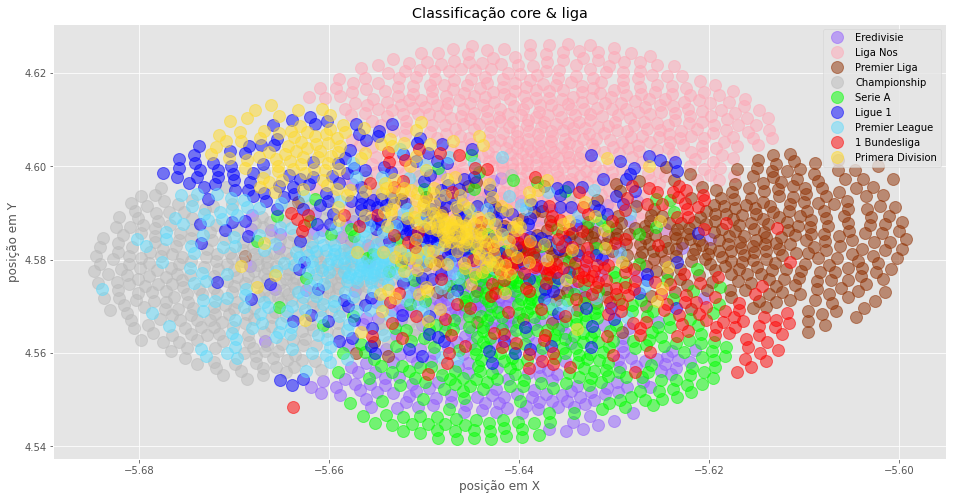

In [22]:
plot_cp(df)

## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [23]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [24]:
DATA_DIR = './data/champions_league'
YEAR = 2003

list_df = loading_champions_data(DATA_DIR, YEAR, 2015)
list_df[1]


,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 13 Jul 2004 (W28),NK Siroki Brijeg › BIH (1),2-1,0-0,Neftchi PFC Baku › AZE (1),NaN,NaN,NaN,NaN
1,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 13 Jul 2004 (W28),Sliema Wanderers › MLT (1),0-2,0-0,FBK Kaunas › LTU (1),NaN,NaN,NaN,NaN
2,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 13 Jul 2004 (W28),FK Pobeda › MKD (1),1-3,0-0,Pyunik › ARM (1),NaN,NaN,NaN,NaN
3,Qualifying,Qual. Round 1 | Leg 1,NaN,(Wed) 14 Jul 2004 (W28),Flora Tallinn › EST (1),2-4,0-0,HNK Gorica › CRO (1),NaN,NaN,NaN,NaN
4,Qualifying,Qual. Round 1 | Leg 1,NaN,(Wed) 14 Jul 2004 (W28),KR Reykjavik › ISL (1),2-2,0-0,Shelbourne › IRL (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
200,Knockout,Semifinals | Leg 1,NaN,(Tue) 26 Apr 2005 (W17),AC Milan › ITA (11),2-0,1-0,PSV Eindhoven › NED (13),NaN,NaN,NaN,NaN
201,Knockout,Semifinals | Leg 1,NaN,(Wed) 27 Apr 2005 (W17),Chelsea FC › ENG (11),0-0,0-0,Liverpool FC › ENG (13),NaN,NaN,NaN,NaN
202,Knockout,Semifinals | Leg 2,NaN,(Tue) 3 May 2005 (W18),Liverpool FC › ENG (14),1-0,1-0,Chelsea FC › ENG (12),1-0 (agg.),NaN,NaN,NaN
203,Knockout,Semifinals | Leg 2,NaN,(Wed) 4 May 2005 (W18),PSV Eindhoven › NED (14),3-1,1-0,AC Milan › ITA (12),(a) 3-3 (agg.),NaN,NaN,Away Goals (2)


In [25]:
def calcula_pontos(stage,round_,time1,time2,time1_placar,time2_placar,comentarios,dict_teams):
    pontos_ = 0
    if stage == 'Qualifying':
        pontos_=1
    elif stage == 'Group':
        pontos_=3
    else:
        pontos_ = 5
    if round_ == 'Final':
        pontos_ = 10
    
    
    if time1 not in dict_teams:
        dict_teams[time1] = 0
        
    if time2 not in dict_teams:
        dict_teams[time2] = 0
        
    if comentarios !=0:
        if comentarios == 1:
            time_vencedor = time1
        if comentarios == 2:
            time_vencedor = time2
    
    if time1_placar > time2_placar:
        time_vencedor = time1
    else:
        time_vencedor = time2
    dict_teams[time_vencedor] +=pontos_


In [26]:
dict_teams = {}
for i in range(len(list_df)):
    list_df[i]['Team 1'] = list_df[i]['Team 1'].str.split(' ›').str[0]
    list_df[i]['Team 2'] = list_df[i]['Team 2'].str.split(' ›').str[0]
    #list_df[i] = list_df[i].dropna(subset=['∑FT'])
    # limpando '∑FT'
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("(","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(")","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("a ","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("agg.","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(" ","")
    list_df[i]['time1_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[0]
    list_df[i]['time2_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[1]
    # limpando P
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace('(','')
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace(")","", regex=True)
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace("pen.","", regex=True)
    list_df[i]['time1_penalti'] = list_df[i]['P'].str.split('-').str[0]
    list_df[i]['time2_penalti'] = list_df[i]['P'].str.split('-').str[1]
    
    # limpando Comments (Away Goals)
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('(','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace(')','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('Away Goals ','')
    
    list_df[i]['time1_placar'] = list_df[i]['FT'].str.split('-').str[0]
    list_df[i]['time1_placar'] = list_df[i]['time1_placar'].str.replace(' ','')
    list_df[i]['time2_placar'] = list_df[i]['FT'].str.split('-').str[1]
    list_df[i] = list_df[i].drop(list_df[i][((list_df[i]['Stage'] == 'Knockout') & (list_df[i]['∑FT'].isnull()) & (list_df[i]['Round'] != 'Final'))].index)

    
    for index, rows in list_df[i].iterrows():
        stage = rows[0]
        round_ = rows[1]
        time1 = rows[4]
        time2 = rows[7]
        comments = rows[11]
        time1_placar_agregado = rows[12]
        time2_placar_agregado = rows[13]
        time1_penalti = rows[14]
        time2_penalti = rows[15]
        time1_placar = rows[16]
        time2_placar = rows[17]
        # checar se houve penalti
        if time1_penalti != 'nan':
            calcula_pontos(stage, round_,time1,time2,int(time1_penalti),int(time2_penalti),0, dict_teams)  
        # checar se teve gol fora de casa 
        elif comments == '1' or comments =='2':
            calcula_pontos(stage, round_,time1,time2,0,0,int(comments),dict_teams)
        # ver se é um jogo com placar agregado
        elif  type(time1_placar_agregado) == str:
            pass
            calcula_pontos(stage, round_,time1,time2,int(time1_placar_agregado),int(time2_placar_agregado),0,dict_teams)
        # passar o placar comum
        else:
            #print(time1_placar[0])
            calcula_pontos(stage, round_,time1,time2,int(time1_placar[0]),int(time2_placar[0]),0,dict_teams)

In [27]:
{k: v for k, v in sorted(dict_teams.items(), key=lambda item: item[1])}


{'Barry Town': 0,
 'Grevenmacher': 0,
 'Flora Tallinn': 0,
 'Glentoran': 0,
 'Rapid Bucuresti': 0,
 'FK Pobeda': 0,
 'Gomel': 0,
 'Jeunesse Esch': 0,
 'Rhyl': 0,
 'PFC Lokomotiv Plovdiv': 0,
 'Banik Ostrava': 0,
 'Dinamo Minsk': 0,
 'Everton FC': 0,
 'TVMK': 0,
 'Apollon Limassol': 0,
 'Shakhtyor Soligorsk': 0,
 'AC Chievo Verona': 0,
 'Metalurgi Rustavi': 0,
 'Murata': 0,
 'Derry City': 0,
 'Marsaxlokk': 0,
 "Ranger's": 0,
 'Zaglebie Lubin': 0,
 'Toulouse FC': 0,
 'Valur Reykjavik': 0,
 'Buducnost': 0,
 'Dinamo Tirana': 0,
 'NSI': 0,
 'Vitoria Guimaraes': 0,
 'Tre Fiori': 0,
 'Makedonija': 0,
 'Kalmar FF': 0,
 'Inter Turku': 0,
 'Sivasspor': 0,
 'Koper': 0,
 'Zeljeznicar Sarajevo': 0,
 'Renova': 0,
 'UC Sampdoria': 0,
 'Bursaspor': 0,
 'Tobol': 0,
 'Bangor City': 0,
 'Borac Banja Luka': 0,
 'Breidablik': 0,
 'Dacia Chisinau': 0,
 'Shkendija': 0,
 'Otelul Galati': 0,
 'Tre Penne': 0,
 'Lusitanos': 0,
 'Ulisses': 0,
 'Feyenoord Rotterdam': 0,
 'Motherwell FC': 0,
 'Nordsjaelland': 0,
 '

In [28]:
#para tirar
list_names_to_remove=[
    'Olimpija Ljubljana','Cwmbran Town','Avenir Beggen',
    'Linfield','FC Norma Tallinn','IA Akranes','AIK Solna','Kispesti Honved',
    'Dunakanyar-Vac','Barry Town','FK Sileks','Crusaders','Lantana Tallinn','FC Jazz',
    'FC Tiraspol','FC Slavia Mozyr','GI Gota','Kosice','Jeunesse Esch','Valletta',
    'B36 Torshavn','FK Vllaznia','FC Yerevan','FK Obilic','IB Vestmannaeyja','Flora Tallinn',
    'KF Tirana','Araks Ararat','Haka Valkeakoski','Dnepr Mogilev','Birkirkara','KR Reykjavik',
    'KI Klaksvik','Crvena Zvezda','NK Brotnjo','Zalgiris Vilnius','The New Saints',
    'Shamkir','Dunaujvaros','Belshina Bobruisk','Dinamo Tirana','Tampere United','FK Leotar',
    'NK Siroki Brijeg','HNK Gorica','PAOK FC','Sioni Bolnisi','FK Modrica','FC Santa Coloma',
    'Drogheda United','FK Mogren','UE Sant Julia','EB / Streymur''Stabaek','Fola Esch','Nomme Kalju'   
]

dict_teams_change={
    'Kobenhavn':'FC Copenhagen',
    'AFC Ajax':'Ajax Amsterdam',
    'Beşiktaş İstanbul JK':'Besiktas',
    'Fenerbahçe İstanbul SK':'Fenerbahce',
    'MTK':'MTK Budapest',
    "St Patrick's Athletic":"St. Patricks",
    "Skonto":"Skonto Riga",
    "Juventus":"Juventus FC",
    "Internazionale":"Inter Milan",
    "FK Zalgiris Vilnius":"Zalgiris",
    "Lille OSC":"LOSC Lille",
    "Vardar Skopje":'Vardar',
    "Celta Vigo":"Celta de Vigo",
    "Kairat":"Kairat Almaty",
    "Dinamo Moskva":'Dinamo Moscow'

}
#count = 0
list_names = []
for name in list(dict_teams.keys()):
    if name not in list(df['name']):
        if name in list_names_to_remove:
            dict_teams.pop(name, None)
        elif name in dict_teams_change:
            dict_teams[dict_teams_change[name]] = dict_teams[name]
            dict_teams.pop(name,None)
        else:
            name_gerado=difflib.get_close_matches(name,list(df['name']),n=1,cutoff=0.5)
            if len(name_gerado)>0:
                dict_teams[name_gerado[0]] = dict_teams[name]
                dict_teams.pop(name,None)
            else:
                print(name)
                dict_teams.pop(name,None)

# # para substituir
# Kobenhavn[FC Copenhagen]
# AFC Ajax[Ajax Amsterdam]
# Beşiktaş İstanbul JK[Besiktas]
# Fenerbahçe İstanbul SK[Fenerbahce]
# MTK[MTK Budapest]
# St Patrick's Athletic[St. Patricks]
#Skonto[Skonto Riga]
#Juventus[Juventus FC]
#Internazionale[Inter Milan],
# FK Zalgiris Vilnius[Zalgiris]
#Lille OSC[LOSC Lille]
#Vardar Skopje[Vardar]
#Celta Vigo[Celta de Vigo]
#Kairat[Kairat Almaty]
#Dinamo Moskva[Dinamo Moscow]

FH
TVMK
NSI
Dnepr Dnepropetrovsk


In [29]:
len(dict_teams)

250

In [30]:
list(df['name'])[1151]

'Stoke U18'

In [31]:
from collections import Counter

a = dict(Counter(list_names))
for k,v in a.items():
    if v ==1:
        print(k,v)

In [32]:
difflib.get_close_matches("Ajax Amsterdam",list(df['name']),n=15,cutoff=0.6)

['Ajax Amsterdam', 'AFC Amsterdam', 'Ajax Amateurs']

In [33]:
len(dict_teams)

250

In [34]:
df[df['name'].str.contains("Vardar")]

,name,league,color,_x,_y,core
1525,Vardar,Liga Nos,16754614,-5.618882,4.599643,0.0


In [35]:
count =0
betweenness, _ = centrality.betweenness(rede_pos_gal)
for v in betweenness:
    print(v)
    if v<0.00001:
        count +=1

0.000968058597019054
0.00043626982237520665
0.0
4.924262162361461e-05
0.0006552344012013466
0.0005077477706164344
0.00279152745963651
0.0013472202904908407
0.0
0.0010726881301653668
0.0006286481776799552
0.0
0.0013707513412627706
0.0
0.0
0.00011334288537755672
0.00038381416505714385
0.0
0.004111034486835227
0.0
0.0008443554009998878
5.2513380661606115e-05
0.0
0.0007010617004361605
0.0
2.184050570120402e-05
0.00019759654079739547
0.00098626605088715
0.00010027299116268413
9.369318961222341e-05
0.0
0.000740938001515419
0.0015034693508742833
0.0006071206623985164
0.0
0.0
0.0
0.0011034252973518913
0.0016228873275485477
0.000572296699836159
0.0
0.0044950012456123145
0.0
0.0002704346882763455
0.0001193086584371178
0.0
0.00010437437695293597
0.0
0.0
0.0012219727170379349
0.0
0.0
0.00025587338231314034
0.0018549880826590872
0.00037018536894769735
0.00013987018906716815
3.8731002899393974e-05
0.00045492915654879386
0.0005364096511627859
0.0
3.47860079385332e-05
0.0004099987003297803
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.5994852525841914e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.000299133111860634
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0001094699062622119
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0002

In [36]:
rede_pos_gal.vp['betweenness'] = betweenness

In [37]:
df = pd.DataFrame({k: list(v) for k, v in rede_pos_gal.vp.items()})

In [38]:
df['pontos'] = 0

In [39]:
for name,pontos in dict_teams.items():
    df.loc[df['name'] == name,'pontos'] = pontos

In [40]:
df

,name,league,color,_x,_y,core,betweenness,pontos
0,Atlético Madrid,Primera Division,16767528,-5.645066,4.585720,1.0,0.000968,119
1,Celta de Vigo,Primera Division,16767528,-5.646331,4.587418,1.0,0.000436,11
2,Boca Juniors,Primera Division,16767528,-5.642760,4.583043,1.0,0.000000,0
3,Albacete Balompié,Primera Division,16767528,-5.645160,4.588430,0.0,0.000049,0
4,RCD Mallorca,Primera Division,16767528,-5.645622,4.585440,1.0,0.000655,0
...,...,...,...,...,...,...,...,...
2825,SC Fortuna Köln,1 Bundesliga,16711680,-5.619049,4.576238,0.0,0.000000,0
2826,Kyung Hee Univ.,1 Bundesliga,16711680,-5.653744,4.603014,0.0,0.000000,0
2827,Odds BK,1 Bundesliga,16711680,-5.617302,4.565498,0.0,0.000000,0
2828,FC Vysocina,1 Bundesliga,16711680,-5.622557,4.592148,0.0,0.000000,0


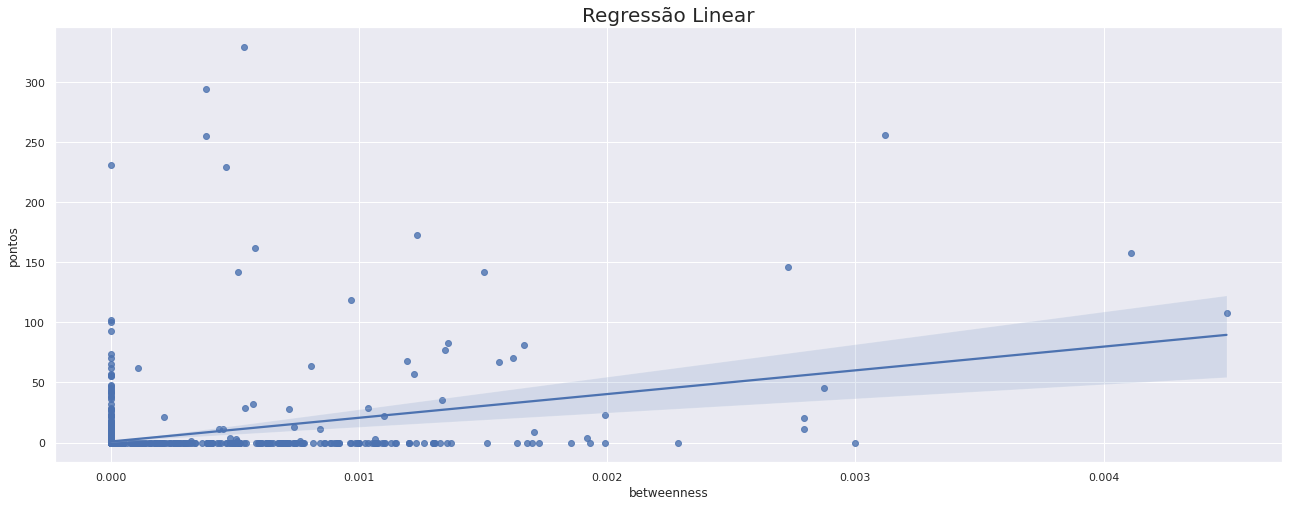

In [41]:
sns.set()

plt.figure(figsize=(22,8))
sns.regplot(x=df['betweenness'], y=df['pontos'])
plt.title("Regressão Linear", fontsize=20)
plt.show()

In [42]:
model = smf.ols(data=df, formula='pontos ~ betweenness')
result_with_zero = model.fit()
result_with_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     384.4
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           2.35e-80
Time:                        00:04:57   Log-Likelihood:                -11696.
No. Observations:                2830   AIC:                         2.340e+04
Df Residuals:                    2828   BIC:                         2.341e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8385      0.290      2.887      0.004       0.269       1.408
betweenness  1.974e+04   1007.086     19.606      0.000    1.78e+04    2.17e+04
==============================================================================
Omnibus:                     4929.401   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4597681.177
Skew:                          12.105   Prob(JB):                         0.00
Kurtosis:                     198.972   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

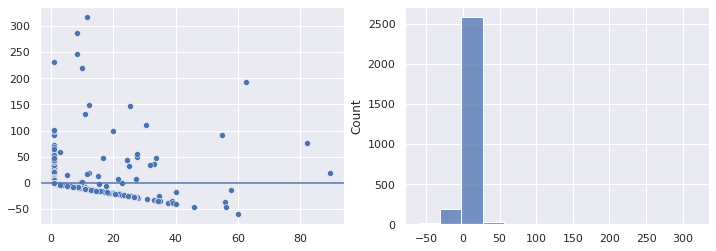

In [44]:
linear_resplot(result_with_zero)

In [45]:
df2 = df[(df['pontos'] > 0)]

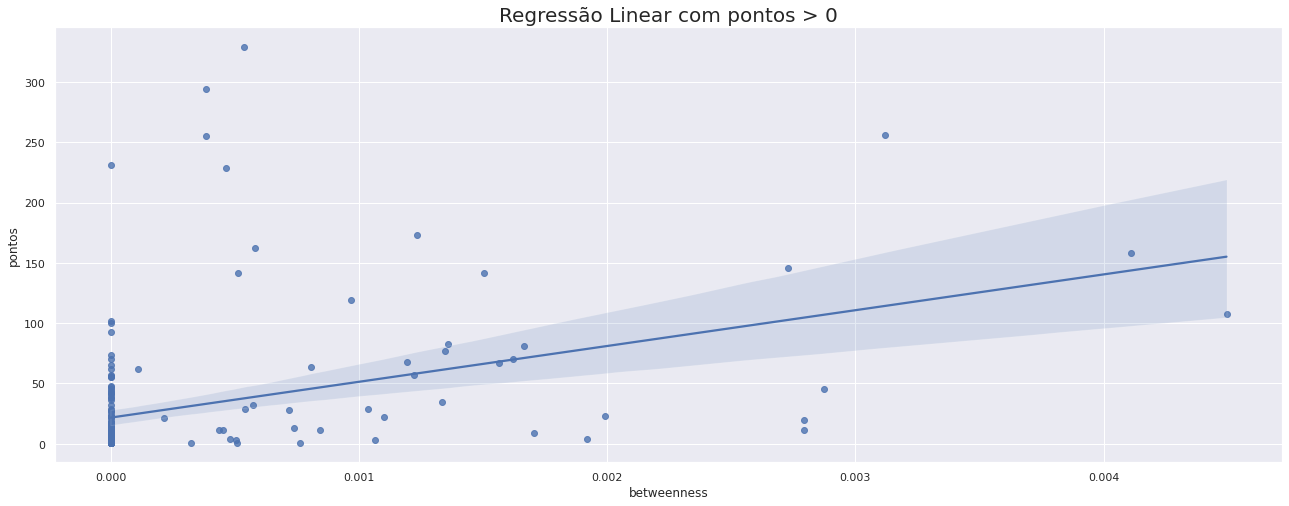

In [46]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df2['betweenness'], y=df2['pontos'])
plt.title("Regressão Linear com pontos > 0", fontsize=20)
plt.show()

In [47]:
model = smf.ols(data=df2, formula='pontos ~ betweenness') 
result_not_zero = model.fit()
result_not_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     35.59
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.19e-08
Time:                        00:04:58   Log-Likelihood:                -1012.9
No. Observations:                 190   AIC:                             2030.
Df Residuals:                     188   BIC:                             2036.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.6680      3.947      5.489      0.000      13.881      29.455
betweenness   2.97e+04   4979.467      5.965      0.000    1.99e+04    3.95e+04
==============================================================================
Omnibus:                      156.710   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1656.007
Skew:                           3.217   Prob(JB):                         0.00
Kurtosis:                      15.953   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

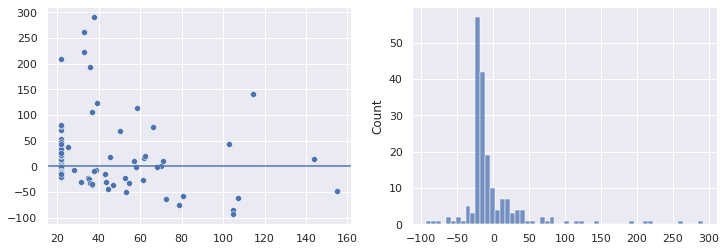

In [48]:
linear_resplot(result_not_zero)

In [49]:
df3 = df[(df['pontos'] > 0) & (df['betweenness'] > 0.0000000001)]

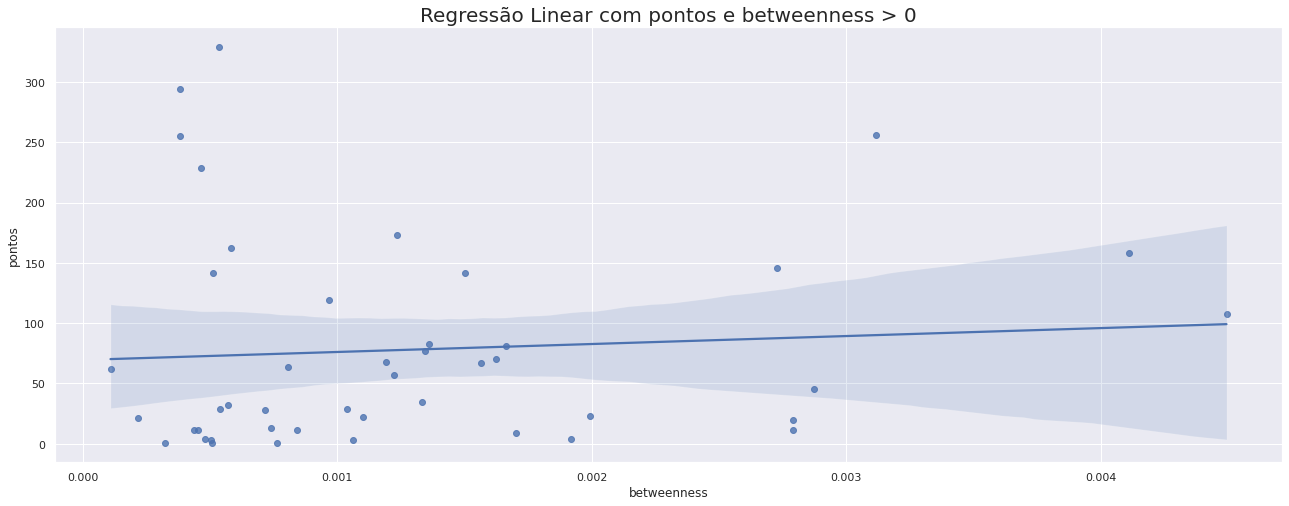

In [50]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df3['betweenness'], y=df3['pontos'])
plt.title("Regressão Linear com pontos e betweenness > 0", fontsize=20)
plt.show()

In [51]:
model = smf.ols(data=df3, formula='pontos ~ betweenness') 
result_not_zero_total = model.fit()
result_not_zero_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.2636
Date:                Tue, 23 Nov 2021   Prob (F-statistic):              0.610
Time:                        00:04:59   Log-Likelihood:                -263.74
No. Observations:                  45   AIC:                             531.5
Df Residuals:                      43   BIC:                             535.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      69.5138     20.964      3.316      0.002      27.235     111.793
betweenness  6608.3436   1.29e+04      0.513      0.610   -1.93e+04    3.26e+04
==============================================================================
Omnibus:                       15.780   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.667
Skew:                           1.417   Prob(JB):                     0.000146
Kurtosis:                       4.182   Cond. No.                         994.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

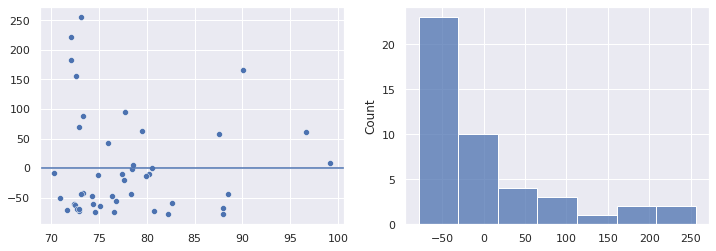

In [52]:
linear_resplot(result_not_zero_total)

In [54]:
df.sort_values(by=['betweenness'], inplace=True, ascending=False)
all_df = df[(df["pontos"] > 70) & (df["betweenness"] > 0.000000000000001)]
all_df[["name", "league", "betweenness", "pontos"]]

,name,league,betweenness,pontos
41,SL Benfica,Primera Division,0.004495,108
18,FC Porto,Primera Division,0.004111,158
145,Chelsea FC,Eredivisie,0.003118,256
98,Liverpool FC,Primera Division,0.002727,146
137,PSV Eindhoven,Eredivisie,0.001664,81
32,Juventus FC,Primera Division,0.001503,142
401,FC Schalke 04,Ligue 1,0.001360,83
7,Valencia CF,Primera Division,0.001347,77
108,AC Milan,Primera Division,0.001236,173
0,Atlético Madrid,Primera Division,0.000968,119
